In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
%matplotlib qt   
# doesn't work on my laptop
from tistools import read_inputfile, get_LMR_interfaces, read_pathensemble, get_weights
from tistools import set_tau_distrib, set_tau_first_hit_M_distrib, cross_dist_distr, pathlength_distr
from tistools import ACCFLAGS, REJFLAGS

from tistools import get_lmr_masks, get_generation_mask, get_flag_mask, select_with_masks
from tistools import unwrap_by_weight, running_avg_local_probs, get_local_probs, get_global_probs_from_dict, get_global_probs_from_local
from tistools import make_plot_trajs

from pprint import pprint    # to print the vars of the pathensemble object

# TODO: change to istar_analysis when finished
# from istar_test import *
from tistools import global_pcross_msm_star, construct_M_istar, get_transition_probs_weights, get_transition_probs_interm, get_simple_probs, get_summed_probs
from tistools import get_weights_staple, compute_weight_matrices, compute_weight_matrix, plot_rv_star, plot_rv_repptis, plot_rv_comp
from tistools import plot_free_energy_landscape, display_data, memory_analysis, ploc_memory, plot_memory_analysis, pcca_analysis

%matplotlib qt

In [2]:
import logging

logger = logging.getLogger(__name__)

In [3]:
%autoreload 2   
# something with pip install -e .

# Reading

In [4]:
# zero_minus_one = True if lambda_-1 interface is set
# zero_minus_one = False if lambda_-1 interface is not set

# data the maze
# ---------------
# indir = indir = "/run/user/1001/gvfs/smb-share:server=files.ugent.be,share=eliawils,user=eliawils/shares/tw06_biommeda_pastime1/11.2024_StapleTIS/simulations/flat/sim_istar0br2108/"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istar2cosbr_2108/"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istarz_g5/"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istarz_slopeg5_2702/"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istar0br2108/"

# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istarwell2_0209/"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istarwell2_br/"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istarwell0_add_0502/"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istarwell0_add_br1703/"
indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istar0br15dintf/"
# indir = "/run/user/1001/gvfs/smb-share:server=files.ugent.be,share=eliawils,user=eliawils/shares/tw06_biommeda_pastime1/11.2024_StapleTIS/simulations/maze2D/sim_istarmaze_kick2708/"
zero_minus_one = False
inputfile = indir + "logging.log"


import os
import glob
os.chdir(indir)
print(os.getcwd())

folders = glob.glob(indir + "/0[0-9][0-9]")
folders = sorted(folders)
print(folders)

/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istar0br15dintf
['/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istar0br15dintf/000', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istar0br15dintf/001', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istar0br15dintf/002', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istar0br15dintf/003', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istar0br15dintf/004', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istar0br15dintf/005', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istar0br15dintf/006', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istar0br15dintf/007', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istar0br

In [5]:
# !!! last lines !!!  allow to speed up this notebook
# pe.set_orders(load=False...)  -> 1st time you run the code, this will store npy files
# pe.set_orders(load=True...)  -> next time you run the code, you can read npy files

# Reading all input
#===================
interfaces, zero_left, timestep = read_inputfile(inputfile)
LMR_interfaces, LMR_strings = get_LMR_interfaces(interfaces, zero_left)
pathensembles = []
for i,fol in enumerate(folders):
    print("#"*80)
    print(fol)
    pe = read_pathensemble(fol+"/pathensemble.txt")
    pe.set_name(fol)
    pe.set_interfaces([LMR_interfaces[i], LMR_strings[i]])
    if i==0:
        pe.set_zero_minus_one(zero_minus_one)   # TODO this is never used
        pe.set_in_zero_minus(True)
    if i==1:
        pe.set_in_zero_plus(True)
    w, _ = get_weights(pe.flags, ACCFLAGS, REJFLAGS, verbose = False)
    pe.set_weights(w)
    print("pathensemble info: ")
    pprint(vars(pe))
    pathensembles.append(pe)
    # read order parameters order.txt/order.npy into path ensemble object
    #pe.set_orders(load=False, acc_only=True, save=False) # if saving doesn't work
    #### CHANGE HERE ####
    # pe.set_orders(load=False, acc_only=True, save=True) # for the 1st time
    # pe.set_orders(load=True, acc_only=True) # for the next times, save=True/False is not important

################################################################################
/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/simulations/sim_istar0br15dintf/000
pathensemble info: 
{'cyclenumbers': array([     0,      1,      2, ...,  99998,  99999, 100000]),
 'dirs': array([0., 0., 0., ..., 0., 0., 0.]),
 'flags': array(['ACC', 'FTL', 'BTL', ..., 'FTL', 'ACC', 'BTL'], dtype='<U3'),
 'generation': array(['ld', 'sh', 'sh', ..., 'sh', 'sh', 'sh'], dtype='<U2'),
 'has_zero_minus_one': False,
 'in_zero_minus': True,
 'in_zero_plus': False,
 'interfaces': [[-0.1, -0.1, -0.1], ['l_[0]', 'l_[0]', 'l_[0]']],
 'istar_idx': array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]]),
 'lambmaxs': array([-0.08388879, -0.08547623, -0.10935451, ..., -0.09938848,
       -0.07520768, -0.13403392]),
 'lambmins': array([-0.13969628, -0.16508488, -0.15096796, ..., -0.19902789,
       -0.13403392, -0.1441625 ]),
 'lengths': array([ 8,  9,  9, 

In [6]:
for pe in pathensembles:
    print(f"ensemble {pathensembles.index(pe)}")
    print(max(pe.lengths))

for i in range(len(pathensembles)):
    accmask = get_flag_mask(pathensembles[i], "ACC")
    loadmask = get_generation_mask(pathensembles[i], "ld")
    mask = get_lmr_masks(pathensembles[i])
    print(i, np.average(select_with_masks(pathensembles[i].lengths, [~loadmask, accmask])))
    print("LMRlen", i, np.average(select_with_masks(pathensembles[i].lengths, [~loadmask, accmask])))

ensemble 0
1340
ensemble 1
624
ensemble 2
602
ensemble 3
712
ensemble 4
675
ensemble 5
778
ensemble 6
749
ensemble 7
768
ensemble 8
761
ensemble 9
698
ensemble 10
698
ensemble 11
726
ensemble 12
691
ensemble 13
755
ensemble 14
695
0 51.54256415171191
LMRlen 0 51.54256415171191
1 27.005563282336578
LMRlen 1 27.005563282336578
2 63.20291832010582
LMRlen 2 63.20291832010582
3 82.9869797271123
LMRlen 3 82.9869797271123
4 92.46625388361281
LMRlen 4 92.46625388361281
5 104.65920155793573
LMRlen 5 104.65920155793573
6 156.85851926977688
LMRlen 6 156.85851926977688
7 125.04959048361934
LMRlen 7 125.04959048361934
8 135.60592349681409
LMRlen 8 135.60592349681409
9 166.8620181249877
LMRlen 9 166.8620181249877
10 151.66531258343824
LMRlen 10 151.66531258343824
11 134.13645089457114
LMRlen 11 134.13645089457114
12 137.1822325252446
LMRlen 12 137.1822325252446
13 137.6335481872907
LMRlen 13 137.6335481872907
14 108.56204568574863
LMRlen 14 108.56204568574863


In [7]:
# plocrepptis, plocistar = cprobs_repptis_istar(pathensembles, interfaces, len(interfaces))
# plocrepptis, plocistar = cprobs_repptis_istar2(pathensembles, interfaces, len(interfaces))

In [8]:
X, wpath, W = display_data(pathensembles, interfaces, len(interfaces))
p = get_transition_probs_weights(wpath)

----------
ENSEMBLE [0-] | ID 0
----------
weights:
accepted      41738
rejected      58263
omitted       0
total trajs   100001
total weights 100001
Sum weights ensemble 0:  0.0

1a. Raw data: unweighted C matrices
C[0] = 
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

1b. Raw data: unweighted path counts with new MD steps

--------------------
ENSEMBLE [0*] | ID 1
--------------------
==== L -> R ====
-> interface 0 is reached, probability to reach interface 1:
    - START at interface 0: 0.18315408369715686 | # weights: 169038.0
-> interface 1 is reached, probability to reach interface 2:
    - START at interface 0: 0.775484496124031 | # weights: 30960.0
-> interface 2 is reached, probability to reach interface 3:
    - START at interface 0: 0.2872672747719605 | # weights: 24009.0
-> interface 3 is reached, probability to reach interface 4:
    - START at interface 0: 0.8597941133826301 | # weights: 6897.0
-> interface 4 is reached, probability to reach interface 5:
    - START at interface 0: 0.23659359190556492 | # weights: 5930.0
-> interface 5 is reached, probability to reach interface 6:
    - START at interface 0: 0.6600142551674982 | # weights: 1403.0
-> interface 6 is reached, probability to reach interface 7:
    - START at interface 0: 0.6414686825053996 | # weights: 926.0
-> interface 7 is re

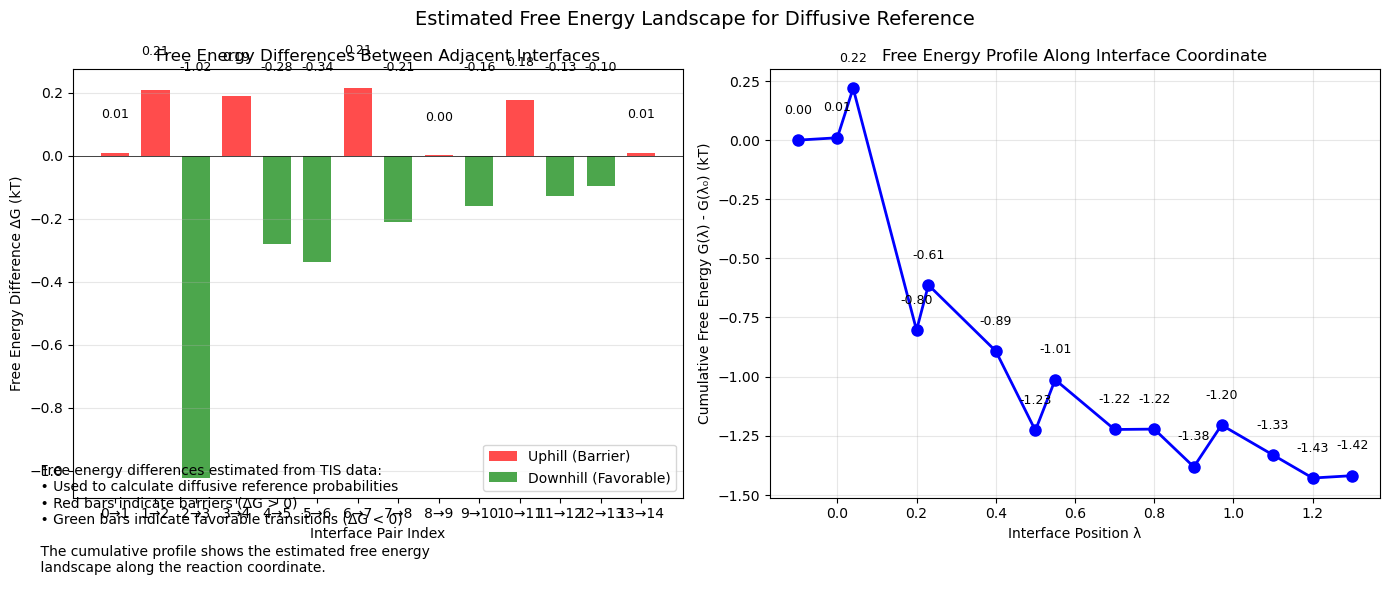

In [ ]:
q_k, q_tot = memory_analysis(wpath, True)
plot_memory_analysis(q_tot, p, interfaces)
# plot_free_energy_landscape(interfaces, q_tot[0], q_tot[1])

In [10]:
ploc_memory(pathensembles, interfaces, trr=True)

Weights of the different paths:
wRMR = 100000
wRML = 0
wLMR = 0
wLML = 0
Local crossing probabilities:
pRMR = 1.0
pRML = 0.0
pLMR = nan
pLML = nan
Local crossing probabilities:
p2R = 1.0
p2L = 0.0
weights:
accepted      41748
rejected      58253
omitted       0
total trajs   100001
total weights 100001
Sum weights ensemble 0:  0.0
weights:
accepted      41777
rejected      58224
omitted       0
total trajs   100001
total weights 100001
Sum weights ensemble 1:  100000.0

Intermediate transition probabilities (q matrix):
[[1.     0.1801]
 [1.     0.    ]]

Final transition probabilities (p matrix):
[[0.8199 0.1801]
 [1.     0.    ]]

Local crossing probabilities computed successfully
Weights of the different paths:
wRMR = 0
wRML = 14677
wLMR = 15842
wLML = 69481
Local crossing probabilities:
pRMR = 0.0
pRML = 1.0
pLMR = 0.18567092108810052
pLML = 0.8143290789118995
Local crossing probabilities:
p2R = 0.15842
p2L = 0.84158
weights:
accepted      41748
rejected      58253
omitted       0
t

{'mlst': [1.0,
  0.18567092108810052,
  0.07983181715451465,
  0.053494791114427946,
  0.04009714575322776,
  0.03198422678669801,
  0.026551870928250666,
  0.022735900230760126,
  0.019947282539219822,
  0.017732724008406718,
  0.015976637798431264,
  0.014534612324791146,
  0.013334719527722062,
  0.012315310794461314,
  0.011440793325265555],
 'apptis': [1.0,
  0.1800732825508464,
  0.10004779314951398,
  0.06916006708823981,
  0.052992554328568836,
  0.04272155377428236,
  0.03584334868059328,
  0.030854311677725375,
  0.027170873550967957,
  0.024202110397844978,
  0.02189091657908896,
  0.019950968935588103,
  0.018354913626203347,
  0.01699633250952364,
  0.01582625532985191],
 'repptis': [1.0,
  0.18567092108810052,
  0.10132955141853796,
  0.06895969599183485,
  0.052505300912791916,
  0.04201238005648256,
  0.03505493163936336,
  0.030118195691495667,
  0.026494116012062797,
  0.023538783474070617,
  0.021239892995709653,
  0.019341928785662713,
  0.017768448661617742,
  0.01

In [11]:
M = construct_M_istar(p, 2*len(interfaces), len(interfaces))
print(np.sum(M, axis=1))
pcca = pcca_analysis(M, 3)

[1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1.]


/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/APPTIS/tistools/lib/istar_analysis.py:1223: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel("Position x (=$\lambda$)")


AssertionError: Rows of the transition matrix must sum to 1.

In [ ]:
print("Using msmtools will also work for hitting probs.")
# Let's try with msmtools, this should definitely work as well.
# I already know I can't solve the MFPT question with this, but 
# this might come in handy whenever we DO include multidimensionality
# from msmtools.analysis import (is_transition_matrix, is_connected, mfpt, 
#                                stationary_distribution, is_reversible)
from deeptime.markov.tools.estimation import is_connected, largest_connected_set, largest_connected_submatrix
from deeptime.markov.tools.analysis import stationary_distribution, is_transition_matrix

print("Using transition matrix with disconnected states: ")
print("is_tmat: ", is_transition_matrix(M))
print("is_connected: ", is_connected(M))
print("largest conn set: ", largest_connected_set(M))
print("stationary_distribution: ", stationary_distribution(largest_connected_submatrix(M)))
# print("is_reversible: ", is_reversible(M))
print("And cutting away the first and last row and column: ")
# print("is_tmat: ", is_transition_matrix(M[1:-1,1:-1]))
print("is_connected: ", is_connected(M[1:-1,1:-1]))
# print("is_reversible: ", is_reversible(M[1:-1,1:-1]))
print("Still disconnected, as we have absorbing states for those hitting state A and B!")
print("Thus, here, we will just work with full M matrix.")
print("Nevermind, we need it to be W E A K L Y connected, so using M[1:-1,1:-1].")

Using msmtools will also work for hitting probs.
Using transition matrix with disconnected states: 
is_tmat:  False
is_connected:  False
largest conn set:  [ 0  1  2  3  4  5  7  9 10 11 12]


ValueError: Input matrix is not a transition matrix. Cannot compute stationary distribution

In [ ]:
# define states A and B
A = [1]
B = [-2]
# Get the committtor probabilities
from msmtools.analysis import committor
from msmtools.flux import tpt
test = tpt(M[1:-1,1:-1], A, B)
print("Same value?", (pmp0plus * plocs[0][-1][1] * test.committor)[0])
print("Real value:", 0.00020540578383777418)
print("So this works as expected")

In [ ]:
# make_plot_trajs("paths002test", "./002", interfaces, 5)

In [ ]:
# if 'repptis' in fol:
#     plot_rv_repptis(pathensembles, interfaces, 3)
# else:
#     plot_rv_star(pathensembles, interfaces, 1)

In [ ]:
# plot_rv_comp(pathensembles, interfaces, 1, 1, (2,4))
# while True:
#     try:
#         plot_rv_comp(pathensembles, interfaces, 1, 1, (2,4))
#         break
#     except:
#         plt.close("all")
#         continue

# Analysis

In [ ]:
# Setting path ensemble properties
#==================================
# for i,fol in enumerate(folders):
#     print(i)
#     if i != 1:
#         print("Calculating path lengths.")
#         set_tau_distrib(pathensembles[i])
#     print("Done.")
#     #else:
#         #TODO problem with ...
#     if i > 1:
#         print("Calculating first hitting lengths to middle interface")
#         set_tau_first_hit_M_distrib(pathensembles[i])
#         print("Done.")
#     #else:
#         # TODO problem with ....

In [ ]:
# Analyze the [i*] simulation.
# Analysis output is saved to the data dictionary.
data = {}

data["running"] = {}

# analysis using all data: ["full"]
# data["full"] = get_transition_probs(pathensembles, interfaces)
# pprint(data)
# print("\n\n")
# data["full"] = get_transition_probzz2(pathensembles, interfaces)
w = compute_weight_matrices(pathensembles, interfaces, tr=True)
for i in range(len(pathensembles)):
    print(f"sum weights pe {i}: ",np.sum(w[i]))

data["full"] = get_transition_probs_weights(w)
# data["full"] = get_transition_probs(w)
data["full1"] = get_simple_probs(w)
# data["full"] = get_summed_probs(pathensembles, interfaces)
pprint(data)

# for i, pe in enumerate(pathensembles):
#     print("doing pathensemble {}".format(i))
#     if i == 0:
#         data[i] = {}
#         continue  # TODO: make [0-] analysis ???

    # masks - TODO not used further on?
    # TODO these functions are duplicate in repptis_analysis
    #masks = get_lmr_masks(pe)
    #loadmask = get_generation_mask(pe, "ld")
    #print("Amount of loads: {}".format(np.sum(loadmask)))
    ##hardloadmask = get_hard_load_mask(loadmask)
    #accmask = get_flag_mask(pe, "ACC")

    # pathtype_cycles
    # pathtypes = ("LML", "LMR", "RML", "RMR")
    # pathtype_cycles = {}
    # for ptype in pathtypes:
    #     pathtype_cycles[ptype] = unwrap_by_weight(
    #             (pe.lmrs == ptype).astype(int), pe.weights)
    
    # # running average analysis: ["running"]
    # data[i] = {}
    # data[i]["running"] = {}
    # data[i]["running"]["plocal"] = {}
    # # you'll still have to hardload select pe.weigths... TODO. # this is comment wouter?
    # for (ptype, p_loc) in zip(pathtypes, 
    #                           running_avg_local_probs(pathtype_cycles, 
    #                                                   pe.weights, tr = False)):
    #     data[i]["running"]["plocal"][ptype] = p_loc

    # analysis using all data: ["full"]
    # plocfull = get_local_probs(pe, tr=False)
    # data[i]["full"] = {}
    # for ptype in pathtypes:
    #     data[i]["full"][ptype] = plocfull[ptype]

    # data[i] have now ["full"] and ["running"]

weights:
accepted      77843
rejected      22158
omitted       0
total trajs   100001
total weights 100001
Sum weights ensemble 0:  0.0
weights:
accepted      58981
rejected      41020
omitted       0
total trajs   100001
total weights 100001
Sum weights ensemble 1:  100000.0
weights:
accepted      50766
rejected      49235
omitted       0
total trajs   100001
total weights 101385
Sum weights ensemble 2:  102327.0
weights:
accepted      54143
rejected      45858
omitted       0
total trajs   100001
total weights 127993
Sum weights ensemble 3:  127991.0
weights:
accepted      48069
rejected      51932
omitted       0
total trajs   100001
total weights 113521
Sum weights ensemble 4:  113515.0
weights:
accepted      54744
rejected      45257
omitted       0
total trajs   100001
total weights 128443
Sum weights ensemble 5:  128441.0
weights:
accepted      51273
rejected      48728
omitted       0
total trajs   100001
total weights 101318
Sum weights ensemble 6:  101317.0
sum weights pe 0: 

In [ ]:

# for i, pe in enumerate(pathensembles):
#     upe = pe.unify_pe()
#     # Pathlength distribution
#     data[i]["pathlengths"] = pathlength_distr(upe)  # these might be used later or not! TODO
        
# #=======================================
# # make figures
# makefigs = True 
# if makefigs:
#     for i, pe in enumerate(pathensembles):     
#         if i == 0:
#             continue
#         # Cross distances distribution
#         L, M, R, lmlpercs, lmllambs, rmrpercs, rmrlambs = cross_dist_distr(pe)
#         fig,ax = plt.subplots()
#         ax.plot(lmllambs, lmlpercs, lw=1, c="g")
#         ax.plot(rmrlambs, rmrpercs, lw=1, c="r")
#         for lamb in (L,M,R):
#             ax.axvline(lamb, color='k', linestyle='--', lw = 0.5)
#         ax.set_xlabel('Cross distance')
#         ax.set_ylabel('Frequency')
#         ax.set_title("Ensemble {}. L = {}, M = {}, R = {}".format(
#             pe.name, L, M, R))
#         ax.set_ylim(0)
#         fig.savefig(f"pathensemble_{i}_crossdist.pdf")
#         plt.close(fig)

#         # Pathlength distribution      
#         for ptype in pathtypes:
#             fig, ax = plt.subplots()
#             ax.plot(data[i]["pathlengths"][ptype]["bin_centers"], 
#                 data[i]["pathlengths"][ptype]["hist"])
#             ax.set_xlabel('Pathlength')
#             ax.set_ylabel('Frequency')
#             ax.set_title(f"{np.sum(data[i]['pathlengths'][ptype]['hist'])} " + \
#                          f"{ptype} paths. ")
#             ax.legend([f"mean = {data[i]['pathlengths'][ptype]['mean']:.2f}, " + \
#                           f"std = {data[i]['pathlengths'][ptype]['std']:.2f}"])
#             fig.savefig(f"pathensemble_{i}_pathlength_{ptype}.pdf")
#             plt.close(fig)

In [ ]:
# Make a figure of the global crossing probabilities
# fig, ax = plt.subplots()
# ax.set_yscale("log")
# ax.plot(Pcrossfull, "o", c = "r")

# cosdip meta
# ax.errorbar([i for i in range(7)], Pcrossfull, yerr=[0, 0.004830, Pcrossfull[2]*0.05068988646, Pcrossfull[3]*0.05189862680, Pcrossfull[4]*0.05071184896, Pcrossfull[5]*0.05083284286, Pcrossfull[6]*0.05067963543], fmt="-o", c = "b", ecolor="r", capsize=6)

# cosbump meta
# ax.errorbar([i for i in range(7)], Pcrossfull, yerr=[0, 0.002535, Pcrossfull[2]*0.04393065503, Pcrossfull[3]*0.04910273500, Pcrossfull[4]*0.05239942040, Pcrossfull[5]*0.05789033634, Pcrossfull[6]*0.0614468], fmt="-o", c = "b", ecolor="r", capsize=6)

# 2 cosdips
# ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.007239, Pcrossfull[2]*0.0414296, Pcrossfull[3]*0.0445266, Pcrossfull[4]*0.0483538], fmt="-o", c = "b", ecolor="r", capsize=6)

# 3 cosbumps
# ax.errorbar([i for i in range(7)], Pcrossfull, yerr=[0, 0.002295, Pcrossfull[2]*0.0328798, Pcrossfull[3]*0.031594, Pcrossfull[4]*0.031474, Pcrossfull[5]*0.03080392, Pcrossfull[6]*0.0308589], fmt="-o", c = "b", ecolor="r", capsize=6)

# 2 cosbumps
#ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.002768, Pcrossfull[2]*0.04440278, Pcrossfull[3]*0.043053, Pcrossfull[4]*0.0463156], fmt="-o", c = "b", ecolor="r", capsize=6)

# flat dt=0.00002 30k cycles
# ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.003294, Pcrossfull[2]*0.07640968, Pcrossfull[3]*0.07789262, Pcrossfull[4]*0.0812692], fmt="-o", c = "b", ecolor="r", capsize=6)

# flat 100k cycles
#ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.002741, Pcrossfull[2]*0.034092, Pcrossfull[3]*0.033621, Pcrossfull[4]*0.0398], fmt="-o", c = "b", ecolor="r", capsize=6)

# ax.set_xlabel("intf")
# ax.set_ylabel(r"$P_A(\lambda_i|\lambda_A)$")
# ax.set_xticks(np.arange(len(interfaces)))
# fig.tight_layout()
# fig.show()
# fig.savefig("Global_probs.pdf")

# print("This should be the same as the repptis_report.pdf value:", Pcrossfull[-1])
# print("which is the case!")
# print("Here, the load immediately disappeared. For a simulation where this is")
# print("not the case, the above code should be adapted a little bit.")

# Now work with MSM

In [ ]:
from tistools import construct_M
from tistools import global_pcross_msm
from tistools import mfpt_to_first_last_state

from tistools import create_labels_states

In [ ]:
def print_vector(g, states=None):
    if states is None:
        for i in range(len(g)):
            print("state", i, g[i])
    else:
        for i in range(len(g)):
            print("state", states[i], g[i][0])

In [ ]:
print(interfaces)
N = len(interfaces)
assert N >= 3
NS = 2*N
print("N", N)
print("NS", NS)

#labels2 = ["0+- LML","0+- LMR","0+- RML","1+- LML","1+- LMR",
#           "1+- RML", "1+- RMR", "2+- LML", "2+- LMR",
#           "2+- RML", "2+- RMR", "3+- LML", "3+- LMR",]
labels1, labels2 = create_labels_states(N)
print(labels1, labels2)

[-0.35, -0.25, -0.125, 0.0, 0.125, 0.25, 0.35]
N 7
NS 14
['0-     ', 'B      '] ['0+- LML', '0+- LMR', '0+- RML', '1+- LML', '1+- LMR', '1+- RML', '1+- RMR', '2+- LML', '2+- LMR', '2+- RML', '2+- RMR', '3+- LML', '3+- LMR', '3+- RML', '3+- RMR', '4+- LML', '4+- LMR', '4+- RML', '4+- RMR', '5+- LML', '5+- LMR']


In [ ]:
p_ini = data["full"]
print("p matrix: ", p_ini)
p_ini[-2][-1] = 1
print("sum rows of p:")
for i in range(p_ini.shape[0]):
    print(np.sum(p_ini[i][:i]), np.sum(p_ini[i][i:]))
M = construct_M_istar(p_ini, NS, N)
M1 = construct_M_istar(data["full1"], NS, N)

# for r in range(M.shape[0]):
#     if np.sum(M[r]) != 0:
#         M[r] /= np.sum(M[r])
#Local crossing probabilities:
#pRMR = 0.34205627942625644.  #ppps
#pRML = 0.6579437205737436.   #ppms
#pLMR = 0.25316455696202533.  #pmps
#pLML = 0.7468354430379747.   #pmms

p matrix:  [[1.75548704e-01 1.46691326e-02 6.39395935e-06 6.08143573e-02
  2.22707863e-01 1.12157273e-02 5.15037822e-01]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 1.37216039e-01
  3.96635828e-01 1.63560748e-02 4.49792058e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.25749988e-01
  4.48488128e-01 1.27495437e-02 3.13012340e-01]
 [2.74886784e-01 1.52395039e-02 7.09873712e-01 0.00000000e+00
  7.13031858e-01 1.58610504e-02 2.71107091e-01]
 [3.12253402e-01 1.37575090e-02 4.49194466e-01 2.24794623e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.61654351e-01 1.67585645e-02 3.74959518e-01 1.46627566e-01
  0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [6.32073273e-01 1.35649184e-02 2.71195595e-01 7.40828782e-02
  0.00000000e+00 9.08333503e-03 0.00000000e+00]]
sum rows of p:
0.0 0.9999999999999998
1.0 1.0
0.0 1.0
1.0 1.0
1.0 0.0
1.0 1.0
1.0 0.0


In [ ]:
print("M")
print("shape", M.shape)
print("sum prob in rows", np.sum(M,axis=1))
print(M)
print(M1)
# row 8, 10, 12, 14. # counting starts from 0   not okay!!!!

M
shape (12, 12)
sum prob in rows [1.         1.         0.99999361 1.         1.         1.
 1.         1.         1.         1.         1.         1.        ]
[[0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.1755487  0.         0.         0.         0.
  0.         0.01466913 0.06081436 0.22270786 0.01121573 0.51503782]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.13721604 0.39663583 0.01635607 0.44979206]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.22574999 0.44848813 0.01274954 0.31301234]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.71303186 0.01586105 0.27110709]
 [0.         0.         0.         0.         0.         0.
  0. 

# Look at this Markov model

In [ ]:
#import numpy.linalg
vals, vecs = np.linalg.eig(M)
print(vals)
vals, vecs = np.linalg.eig(M.T)
print(vals)

[ 0.00000000e+00+0.j          9.99998391e-01+0.j
 -4.06475700e-01+0.75408496j -4.06475700e-01-0.75408496j
 -6.94232447e-01+0.j          5.36024797e-01+0.j
  2.34678995e-01+0.j         -2.35629130e-01+0.j
 -2.75399289e-02+0.j         -5.82729603e-03+0.j
  5.47801777e-03+0.j          5.90239634e-16+0.j        ]
[ 9.99998391e-01+0.j         -4.06475700e-01+0.75408496j
 -4.06475700e-01-0.75408496j -6.94232447e-01+0.j
  5.36024797e-01+0.j          2.34678995e-01+0.j
 -2.35629130e-01+0.j         -2.75399289e-02+0.j
 -5.82729603e-03+0.j          5.47801777e-03+0.j
  4.49486924e-17+0.j          0.00000000e+00+0.j        ]


In [ ]:
print("what if chain propagates")
print("A[0,:]")
# check stationary behavior
A = M
for n in range(10):
    A = np.dot(A,M)
    #print(A)
    print(A[0,:])
    print(np.sum(A[0,:]))  # is 1 indeed

what if chain propagates
A[0,:]
[0.         0.1755487  0.         0.         0.         0.
 0.         0.01466913 0.06081436 0.22270786 0.01121573 0.51503782]
0.9999936060406505
[0.69058653 0.10610527 0.         0.00417865 0.1474151  0.05170806
 0.         0.         0.         0.         0.         0.        ]
0.9999936060406506
[0.10610527 0.         0.69058653 0.         0.         0.
 0.         0.         0.03385233 0.10464082 0.00276797 0.06204069]
0.9999936060406507
[0.06204069 0.16448942 0.10610527 0.00200188 0.07207283 0.02392855
 0.         0.01013031 0.04199758 0.15379905 0.00774543 0.35567818]
0.9999891904584801
[0.5201676  0.09190151 0.06204069 0.00288572 0.10180288 0.03570889
 0.         0.00155647 0.02299785 0.07381013 0.00252122 0.08459554]
0.9999885120256778
[0.17649706 0.04298084 0.5201676  0.00140817 0.05042603 0.0169618
 0.         0.00091008 0.02715093 0.08608049 0.00260735 0.07479777]
0.9999881153400327
[0.1177786  0.12777088 0.17649706 0.00164172 0.05891826 0.019

# Pcross with MSM

In [ ]:
# global crossing prob
z1, z2, y1, y2 = global_pcross_msm_star(M, True)
print("Z")
print_vector(z1, labels1)
print_vector(z2, labels2)
print("Y")
print_vector(y1, labels1)
print_vector(y2, labels2)
print("global crossing prob", y1[0])


=== Eigenvalue Analysis ===
Mp eigenvalues: [ 0.     -0.6941  0.6941 -0.2346 -0.0058  0.0058  0.2346  0.      0.    ]
(I-Mp) eigenvalues: [1.     0.3059 1.6941 0.7654 0.9942 1.0058 1.2346 1.     1.    ]

=== Matrix Components ===
D (transitions from intermediate to boundary states):
[[0.     0.515 ]
 [0.     0.4498]
 [0.     0.313 ]
 [0.     0.2711]
 [0.     1.    ]
 [0.     0.    ]
 [0.     0.    ]
 [0.     0.    ]
 [0.     0.    ]]

E (transitions from boundary to intermediate states):
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]

M11 (transitions between boundary states):
[0. 0.]

=== Solution Vectors ===
z1 (boundary states solution):
[[0]
 [1]]

z2 (intermediate states solution):
[[0.6349]
 [0.6746]
 [0.596 ]
 [0.5641]
 [1.    ]
 [0.    ]
 [0.4334]
 [0.4038]
 [0.3175]]

=== Result Vectors ===
y1 (boundary states result):
[[0.6349]
 [0.    ]]

y2 (intermediate states result):
[[0.6349]
 [0.6746]
 [0.596 ]
 [0.5641]
 [1.    ]
 [0.    ]
 [0.4334]
 [0.4038]
 [0.3175]]

In [ ]:
# P_loc with MSM
plocMSM = np.ones(len(interfaces))
# p2 = [1.0, 0.056804159591634415, 0.032312997136678026, 0.018071661236763906, 0.009174080897093834, 0.004218791762213937, 0.0019851528367788125, 0.0015222409020198072, 0.001318390278132916, 0.0011178599945945473, 0.0009802371708142466]
# p2 = [1.0, 0.8272598636455519, 0.8118884810440299, 0.7938415404869816, 0.5663700466714486, 0.5545303803303038]
# p2 = [1.0, 0.055139270922254895, 0.03126608951116539, 0.017392262443045026, 0.008894249404190929, 0.0040038338896561795, 0.0010513581251145503, 0.0010513581251145503, 0.0010513581251145503, 0.0010513581131851855, 0.0010513580976654149]
# p3 = [1.0, 0.062089, 0.035751653, 0.02010748, 0.010213876, 0.004782699, 0.001383816, 0.000568035, 0.000547059, 0.000516629, 0.000493516]
# p3 = [1.0, 0.810296, 0.796242226, 0.78048937, 0.636988594, 0.625611341]
# p3 = [1.0, 0.059440, 0.575552, 0.565633, 0.517311, 0.461832, 0.259615, 0.368699, 0.992271, 0.999820, 0.987496]
# p3 = [np.prod(p3[:i+1]) for i in range(len(p3))]

for lint in range(2, len(interfaces)+1):
    wi = compute_weight_matrices(pathensembles[:lint], interfaces[:lint], len(interfaces), True)
    pi = get_transition_probs_weights(wi)
    # pi = get_transition_probs(wi)
    # pi = get_simple_probs(wi)
    Mi = construct_M_istar(pi, max(4, 2*len(interfaces[:lint])), len(interfaces[:lint]))
    z1, z2, y1, y2 = global_pcross_msm_star(Mi)
    plocMSM[lint-1] = y1[0][0]
    print(f"ploc till intf {lint-1}: ", y1[0][0])

# Make a figure of the global crossing probabilities
plt.rcParams['text.usetex'] = True
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.plot(plocMSM, "o", c = "r")
ax.errorbar([i for i in range(len(plocMSM))], plocMSM, fmt="-o", c = "b", ecolor="r", capsize=6, label="StapleTIS")
# ax.errorbar([i for i in range(len(plocMSM))], p2, fmt="-o", c = "orange", ecolor="r", capsize=6., label="REPPTIS")
# ax.errorbar([i for i in range(len(plocMSM))], p3, fmt="-o", c = "r", ecolor="r", capsize=6., label="RETIS")
ax.set_xlabel(r"Interface index")
ax.set_ylabel(r"$P_A(\lambda_i|\lambda_A)$")
ax.set_xticks(np.arange(len(interfaces)))
fig.tight_layout()
fig.legend()
fig.show()


weights:
accepted      39957
rejected      60044
omitted       0
total trajs   100001
total weights 100001
sum weights ensemble 0= 0.0
weights:
accepted      38757
rejected      61244
omitted       0
total trajs   100001
total weights 100001
sum weights ensemble 1= 99998.0
0.0 [0. 0.] 1 0
q:  [[1.         0.08981925]
 [0.         0.        ]]
p:  [[0.91018075 0.08981925]
 [0.         0.        ]]
Local crossing probabilities computed
ploc till intf 1:  0.08981924986240757
weights:
accepted      39957
rejected      60044
omitted       0
total trajs   100001
total weights 100001
sum weights ensemble 0= 0.0
weights:
accepted      38757
rejected      61244
omitted       0
total trajs   100001
total weights 100001
sum weights ensemble 1= 99998.0
weights:
accepted      51081
rejected      48920
omitted       0
total trajs   100001
total weights 122225
sum weights ensemble 2= 171384.0
0 0 2 0.5403749317478614 16483.0
1 0 2 0.5268347225045741 98380.0
1 1 0 1.0 46550.0
1 1 2 1.0 73004.0
1 2 0 0

In [ ]:
print(plocMSM)
for pp in plocMSM:
    print(pp)
print("\n\n")
pcrosslocMSM = np.empty(len(plocMSM))

for i in range (len(pcrosslocMSM)):
    pcrosslocMSM[i] = plocMSM[i]/np.prod(pcrosslocMSM[:i])
    print(pcrosslocMSM[i])
    

[1.         0.08981925 0.04959346 0.03410001 0.02594881 0.02101857
 0.01758671 0.01516782 0.01335544 0.01189572 0.01073326 0.00976667
 0.00895838 0.00827139 0.00769619]
1.0
0.08981924986240757
0.049593456377752296
0.03410000609759861
0.02594880605802182
0.021018571283703148
0.01758670960716616
0.01516782448607984
0.013355435799743553
0.011895721348228538
0.010733260891365039
0.009766674332990784
0.008958380274750754
0.008271391878372591
0.007696190401970933



1.0
0.08981924986240757
0.5521473008706217
0.6875908353283464
0.7609619184158793
0.8100014789391613
0.8367224094247596
0.8624594836034204
0.8805109666188718
0.8907025968000951
0.9022791117214083
0.9099447438986712
0.9172395811837711
0.923313325031039
0.930458925793898


In [ ]:
# Plot network
def plot_network(P, figname, source=None, target=None):
    """
    Network plots
    =============
    
    We demonstrate different kinds of network plots based on :meth:`plots.Network <deeptime.plots.Network>`.
    In particular:
    
        * plotting a Markov state model where the state sizes depend on the stationary distribution and edges are scaled
          according to jump probabilities (:meth:`deeptime.plots.plot_markov_model`)
        * plotting the gross flux, in accordance to edge widths and colored according to the forward committor
          (:meth:`deeptime.plots.Network`).
    """
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import networkx as nx
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    from deeptime.markov.msm import MarkovStateModel
    from deeptime.plots import plot_markov_model, Network, plot_flux
    
    if source is None:
        source = 0
    elif target is None:
        target = len(P)-1

    f1, axes1 = plt.subplots(figsize=(16, 12))
    axes1.set_aspect('equal')
    f2, axes2 = plt.subplots(figsize=(16, 12))
    axes2.set_aspect('equal')
    f3, axes3 = plt.subplots(figsize=(16, 12))
    axes3.set_aspect('equal')

    ax = axes1
    ax.set_title('Plotting the Markov model')
    plot_markov_model(P, ax=ax)
    
    ax = axes2
    ax.set_title('Plotting the gross flux')
    flux = MarkovStateModel(P).reactive_flux(source_states=source,
                                             target_states=target)
    positions = nx.multipartite_layout(nx.from_numpy_array(flux.gross_flux))
    #cmap = mpl.cm.get_cmap('coolwarm')
    cmap = mpl.colormaps['coolwarm'] #m.get_cmap('coolwarm')
    network = Network(flux.gross_flux, positions, edge_curvature=2.,
                      state_colors=flux.forward_committor, cmap=cmap)
    network.plot(ax=ax)
    norm = mpl.colors.Normalize(vmin=np.min(flux.forward_committor), vmax=np.max(flux.forward_committor))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    f1.colorbar(mpl.cm.ScalarMappable(norm, cmap), cax=cax)
    
    ax = axes3
    ax.set_title('Plotting the net flux')
    ax.get_yaxis().set_visible(False)
    plot_flux(flux, attribute_to_plot='net_flux', ax=ax)
    
    plt.show()
    # f.savefig(figname)

In [ ]:
A = [0]
B = [len(M)-1]

plot_network(M, "fig_try-plot-network-M.png", source=A, target=B)
# from deeptime.plots import plot_markov_model, Network, plot_flux
# plot_markov_model(M)

# Error analysis (recursive block analysis)

In [ ]:
# PyRETIS code for block error analysis
 
def block_error(data, maxblock=None, blockskip=1):
    """
    Perform block error analysis to estimate the standard deviation in the input data.

    Parameters
    ----------
    data : numpy.array
        The data to analyze.
    maxblock : int, optional
        Maximum block length to consider. Defaults to half the length of the input data.
    blockskip : int, optional
        Skip factor for block lengths. Defaults to 1 (all block lengths considered).

    Returns
    -------
    blocklen : numpy.array
        Array of block lengths considered.
    block_avg : numpy.array
        Block averages as a function of block length.
    block_err : numpy.array
        Standard error estimates as a function of block length.
    block_err_avg : float
        Average error estimate for block lengths greater than maxblock//2.
    """
    n = len(data)
    maxblock = min(maxblock or n // 2, n // 2)
    
    blocklen = np.arange(1, maxblock + 1, blockskip, dtype=np.int_)
    n_blocks = len(blocklen)
    
    block = np.zeros(n_blocks)
    nblock = np.zeros(n_blocks)
    block_avg = np.zeros(n_blocks)
    block_var = np.zeros(n_blocks)

    for i, val in enumerate(data):
        block += val
        full_blocks = (i + 1) % blocklen == 0
        block[full_blocks] /= blocklen[full_blocks]
        nblock[full_blocks] += 1
        deltas = block[full_blocks] - block_avg[full_blocks]
        block_avg[full_blocks] += deltas / nblock[full_blocks]
        block_var[full_blocks] += deltas * (block[full_blocks] - block_avg[full_blocks])
        block[full_blocks] = 0.0

    block_var /= (nblock - 1)
    block_err = np.sqrt(block_var / nblock)
    
    large_blocks = blocklen > maxblock // 2
    block_err_avg = np.mean(block_err[large_blocks])
    
    return blocklen, block_avg, block_err, block_err_avg, maxblock, n//maxblock


def block_error_corr(data, maxblock=None, blockskip=1):
    """
    Run block error analysis and calculate correlation length estimates.

    Parameters
    ----------
    data : numpy.array
        Data to analyze.
    maxblock : int, optional
        Maximum block length to consider. Defaults to half the length of the input data.
    blockskip : int, optional
        Skip factor for block lengths. Defaults to 1 (all block lengths considered).

    Returns
    -------
    blen : numpy.array
        Block lengths considered.
    berr : numpy.array
        Error estimates as a function of block length.
    berr_avg : float
        Average error estimate for blocks with length > maxblock // 2.
    rel_err : numpy.array
        Relative error normalized by the overall average as a function of block length.
    avg_rel_err : float
        Average relative error for blocks with length > maxblock // 2.
    ncor : numpy.array
        Estimated correlation length as a function of block length.
    avg_ncor : float
        Average correlation length for blocks with length > maxblock // 2.
    """
    blen, bavg, berr, berr_avg, max_block_size, min_block_number = block_error(data, maxblock=maxblock, blockskip=blockskip)
    rel_err = berr / abs(bavg[0])
    avg_rel_err = berr_avg / abs(bavg[0])
    ncor = (berr / berr[0])**2
    avg_ncor = (berr_avg / berr[0])**2
    
    return blen, berr, berr_avg, rel_err, avg_rel_err, ncor, avg_ncor, max_block_size, min_block_number

def pathensembles_nskip(obj, nskip):
    keys = [
        'cyclenumbers', 'flags', 'generation', 'lambmaxs', 'lambmins',
        'lengths', 'lmrs', 'newpathnumbers', 'pathnumbers',
        'shootlinks', 'weights', 'dirs', 'istar_idx']
    for key in keys:
        attr = getattr(obj, key)
        setattr(obj, key, attr[:nskip])

In [ ]:
%%capture
from datetime import datetime
import copy

start_cyc = 1
n_cycle = 100000
nstep = 1

ploc_MSM_stored = []
ploc_repptis_stored = []
# This loops over the npy file and calculates tau from cycle 100 every 10 cycles
for nskip in range(start_cyc, n_cycle, nstep):
    pathensemblesi = copy.deepcopy(pathensembles)
    for i, pe in enumerate(pathensemblesi):
        pathensembles_nskip(pe,nskip)
    # Analysis output is saved to the data dictionary.
    data = {}
    for i, pe in enumerate(pathensemblesi):
        if i == 0:
            data[i] = {}
            continue  #  [0-] is not used for Pcross calculations
        
        # Classify the paths according to their path type.
        pathtypes = ("LML", "LMR", "RML", "RMR")
        pathtype_cycles = {}
        for ptype in pathtypes:
            pathtype_cycles[ptype] = unwrap_by_weight(
                    (pe.lmrs == ptype).astype(int), pe.weights)
        
        data[i] = {}
        plocfull = get_local_probs(pe, tr=False)
        data[i]["full"] = {}
        for ptype in pathtypes:
            data[i]["full"][ptype] = plocfull[ptype]

    psfull = []
    for i in range(1, len(pathensemblesi)):   # do not use the 0- ensemble
        psfull.append({"LMR": data[i]["full"]["LMR"], 
                "RML": data[i]["full"]["RML"], 
                "RMR": data[i]["full"]["RMR"],
                "LML": data[i]["full"]["LML"]})

    Pminfull, Pplusfull, Pcrossfull = get_global_probs_from_dict(psfull)

    ploc_repptis_stored.append(Pcrossfull)
    
    N = len(interfaces)
    NS = 2*N

    wi = compute_weight_matrices(pathensemblesi, interfaces, len(interfaces), True)
    pi = get_transition_probzz(wi)
    # pi = get_transition_probs(wi)
    # pi = get_simple_probs(wi)
    M = construct_M_istar(pi, max(4, 2*len(interfaces)), len(interfaces))

    plocMSM = np.ones(len(interfaces))
    for lint in range(1, len(interfaces)):
        # Mi = M[:min(NS, 1+2*lint), :min(NS, 1+2*lint)]
        Mi = M[np.r_[0:2+lint, 1+N:N+lint, -1]]
        Mi = Mi[:, np.r_[0:2+lint, 1+N:N+lint+1]]
        Msum = M[np.r_[0:2+lint, 1+N:N+lint+1]]
        Mi[:, -1] = np.sum(Msum[:, N+lint:], axis=1)
        
        # wi2 = compute_weight_matrices(pathensemblesi[:lint+1], interfaces[:lint+1], len(interfaces), True)
        # pi2 = get_transition_probzz(wi2)
        # # pi = get_transition_probs(wi)
        # # pi = get_simple_probs(wi)
        # Mi2 = construct_M_istar(pi2, max(4, 2*len(interfaces[:lint+1])), len(interfaces[:lint+1]))

        # print(Mi == Mi2)

        z1, z2, y1, y2 = global_pcross_msm_star(Mi)
        plocMSM[lint] = y1[0][0]
    # print(f"plocs: ", plocMSM)

    pcrosslocMSM = np.empty(len(plocMSM))

    for i in range (len(pcrosslocMSM)):
        pcrosslocMSM[i] = plocMSM[i]/np.prod(pcrosslocMSM[:i])
    # print(pcrosslocMSM)

    ploc_MSM_stored.append(plocMSM)

    # for i,fol in enumerate(folders):
    #     set_tau_distrib(pathensemblesi[i])
    #     if True:
    #         set_tau_first_hit_M_distrib(pathensemblesi[i])

    # Compute taus for pathlength analysis
    timestamp = datetime.now().strftime("%H:%M:%S")
    print(f"{nskip:5d} cycles, Plocs {plocMSM}")

    # Not sure if we need this, need to check later
    del data
    del Mi, wi, pi, z1, z2, y1, y2,N, NS
    del Pcrossfull, Pminfull, Pplusfull
    del plocMSM, pcrosslocMSM

np.save('plocMSM_vs_cycle_interval_1_full.npy', ploc_MSM_stored)
np.save('plocREPPTIS_vs_cycle_interval_1_full.npy', ploc_repptis_stored)

In [ ]:
# Adapted AG, Jan 17, 2025

#----------------
# part Titus
#----------------

# SETTINGS

minblocks = 5 #the minimal number of blocks
filerunav = "plocMSM_vs_cycle_interval_1_full.npy"

# FUNCTIONS

def get_second_column(file):
    arr = []
    with open(file, "r") as f:
        for line in f:
            values = line.strip().split()
            arr.append(float(values[1]))
    return arr
 
def get_first_column(file):
    arr = []
    with open(file, "r") as f:
        for line in f:
            values = line.strip().split()
            arr.append(float(values[0]))
    return arr
 
def rec_blocks(r):
    # no longer used
    """Compute the vector b, which is ... """
    b = np.zeros(len(r))
    for i in range(len(r)):
        if i == 0:
            b[i] = r[i]
        else:
            b[i] = (i+1) * r[i] - i * r[i - 1]
    return b
 
def rec_blocks_from_runav(runav, n):
    # see paper Vervust et al. PyRETIS3, 2024
    # paper: select values k[j*m], indexing starts at 1
    # here: runav, python indexing, so start index n-1 (end of first block)
    # collect them in runav_red
    assert n>0   # block size
    runav_red = runav[n-1::n]
    nb = len(runav_red)  # number of blocks
 
    # array b with average of each block
    b = np.zeros(nb)
    for i in range(nb):
        if i == 0:
            b[i] = runav_red[i]
        else:
            b[i] = (i+1) * runav_red[i] - i * runav_red[i - 1]
    return b
 
def compute_absolute_error(runavfull, bestav, n):
    # compute average in each block
    assert n>0
    blocks = rec_blocks_from_runav(runavfull, n)
    # compute standard deviation between blocks
    sum_qudiff = np.sum((blocks-bestav)**2)
    nb = len(blocks)
    assert nb>1
    Aerr2 = sum_qudiff/(nb*(nb-1))
    Aerr = np.sqrt(Aerr2)  #esitimate of absolute error
    return Aerr
 
 
# GET STARTED
 
# runavfull = get_second_column(filerunav) #all the running average data in an array
runavfull = np.load(filerunav)
runavfull = runavfull[5:,:]
maxbll = int(len(runavfull)/minblocks) #maximum block length
bestav = runavfull[-1] #most accurate average we have
print("maximum block length = ", maxbll)
 
# loop over block size
sizes = np.arange(1,maxbll+1)
if len(np.shape(runavfull)) == 1:
    rel_errors = np.zeros(len(sizes)) if len(np.shape(runavfull)) == 1 else np.zeros((len(sizes), np.shape(runavfull)[1]))
    for i, n in enumerate(sizes):
        # n is block size
        Aerr = compute_absolute_error(runavfull, bestav, n)
        Rerr = Aerr/bestav
        rel_errors[i] = Rerr
    
    second_half = rel_errors[len(rel_errors)//2:]
    half_av_err = np.mean(second_half)
    print("estimated relative error=", half_av_err)
    Nstatineff=(half_av_err/rel_errors[0])**2
    print("statistical inefficiency=", Nstatineff)
    
    plt.figure()
    plt.plot(sizes, rel_errors)
    plt.axhline(y=half_av_err, color='r', linestyle='--')
    plt.xlabel('Block Length')
    plt.ylabel('Relative Error')
    plt.title('Error Analysis')
    plt.show()
    # plt.savefig("figure_titus.png")

elif len(np.shape(runavfull)) == 2:
    rel_errs = np.empty(len(interfaces))
    for loc in range(len(interfaces)):
        rel_errors = np.zeros(len(sizes))
        intf_i = runavfull[:,loc]
        bestav = intf_i[-1]
        for i, n in enumerate(sizes):
        # n is block size
            Aerr = compute_absolute_error(intf_i, bestav, n)
            Rerr = Aerr/bestav
            rel_errors[i] = Rerr

        second_half = rel_errors[len(rel_errors)//2:]
        half_av_err = np.mean(second_half)
        rel_errs[loc] = half_av_err
        print("estimated relative error=", half_av_err)
        Nstatineff=(half_av_err/rel_errors[0])**2
        print("statistical inefficiency=", Nstatineff)
        
        plt.figure()
        plt.plot(sizes, rel_errors)
        plt.axhline(y=half_av_err, color='r', linestyle='--')
        plt.xlabel('Block Length')
        plt.ylabel('Relative Error')
        if loc < len(interfaces)-1:
            plt.title('Error Analysis $p_{local}$'+f' - interface {loc}')
        else:
            plt.title('Error Analysis $P_{cross}$')
        plt.show()
        # plt.savefig("figure_titus.png")

maximum block length =  19998
estimated relative error= 0.0
statistical inefficiency= nan


/tmp/ipykernel_400959/1067094454.py:122: RuntimeWarning: invalid value encountered in scalar divide
  Nstatineff=(half_av_err/rel_errors[0])**2


estimated relative error= 0.035026263859068325
statistical inefficiency= 12.803962037331534
estimated relative error= 0.03629506752480279
statistical inefficiency= 12.30855799268715
estimated relative error= 0.03860426506193927
statistical inefficiency= 13.119834706021457
estimated relative error= 0.04187121021039022
statistical inefficiency= 14.386298466893177
estimated relative error= 0.043738990358359854
statistical inefficiency= 14.632355747315064
estimated relative error= 0.0496850196134735
statistical inefficiency= 16.65657467803505
estimated relative error= 0.07627598921717178
statistical inefficiency= 36.33504361711302
estimated relative error= 0.07892064974077292
statistical inefficiency= 38.587801289250514
estimated relative error= 0.08168128812169928
statistical inefficiency= 41.15697280835939
estimated relative error= 0.08358957475156441
statistical inefficiency= 42.79071205318213


In [ ]:
stored_values = np.load('plocREPPTIS_vs_cycle_interval_10.npy')

if len(np.shape(stored_values)) == 1:
    stored_values = stored_values[~np.isnan(stored_values)] # remove nans in the beginning
    blen, berr, berr_avg, rel_err, avg_rel_err, ncor, avg_ncor, max_block_size, min_block_number = block_error_corr(stored_values,10)
    print("=" * 60)
    print(indir[57:-9])
    print(f"Total Data Points: {len(stored_values)}, max block size: {max_block_size}, min block number: {min_block_number}")
    print(f"Average Relative Error for blocks > maxblock/2: {avg_rel_err * 100:.1f}%")
    print(f"Average Correlation Length for Large Blocks: {int(avg_ncor)}")
    plt.figure(figsize=(8, 6))
    plt.plot(rel_err, marker='o', linestyle='-', label = indir[57:-9])
    plt.xlabel("Block Size")
    plt.ylabel("Rlative Error")
    plt.title(f"Ave Rel Err (blocks > maxblock/2): {avg_rel_err * 100:.1f}%, Block interval 10 cycles")
    plt.grid(True)
    plt.legend()
    # plt.savefig("Block_Error_Tau.png", dpi=1000, bbox_inches='tight')
elif len(np.shape(stored_values)) == 2:
    rel_errs = np.empty(len(interfaces))
    for loc in range(1,len(interfaces)):
        intf_i = stored_values[:,loc]
        blen, berr, berr_avg, rel_err, avg_rel_err, ncor, avg_ncor, max_block_size, min_block_number = block_error_corr(intf_i[~np.isnan(intf_i)],1000)
        rel_errs[loc] = avg_rel_err

        print("=" * 60)
        print(indir[57:-9])
        print(f"Total Data Points: {len(stored_values)}, max block size: {max_block_size}, min block number: {min_block_number}")
        print(f"Average Relative Error for blocks > maxblock/2: {avg_rel_err * 100:.10f}%")
        print(f"Average Correlation Length for Large Blocks: {int(avg_ncor)}")
        plt.figure(figsize=(8, 6))
        plt.plot(rel_err, linestyle='-', label = indir[57:-9])
        plt.xlabel("Block Size")
        plt.ylabel("Rlative Error")
        plt.title(f"Ave Rel Err (blocks > maxblock/2): {avg_rel_err * 100:.1f}%, Block interval 10 cycles")
        plt.grid(True)
        plt.legend()
        # plt.savefig("Block_Error_Tau.png", dpi=1000, bbox_inches='tight')

# Bootstrap 👢 analysis

In [ ]:
from tistools import bootstrap_istar_analysis

In [ ]:
from tistools import find_closest_number_lte
def bootstrap_istar_analysis2(pathensembles, interfaces, nN=10, nB=1000):
    N = len(interfaces)
    NS = max(3, 2*len(interfaces))
    data = {}
    # for each pathensemble, we save the indices of accepted cycle numbers in a
    # dictionary, because we will use this a lot. We do not accept load cycles, 
    # so if a load cycle is sampled, we will just not use it. 
    pathcycle_ids = {}
    for i, pe in enumerate(pathensembles):
        loadmask = get_generation_mask(pe, "load")
        accmask = get_flag_mask(pe, "ACC")
        pathcycle_ids[i] = select_with_masks(pe.cyclenumbers,
                                             [accmask, ~loadmask])
    for Bcycle in np.arange((pathensembles[0].cyclenumbers)[-1]//nN,
                            (pathensembles[0].cyclenumbers)[-1],
                            ((pathensembles[0].cyclenumbers)[-1]//nN)):
        logger.info(f"Doing bootstrap analysis for cycle {Bcycle}")
        # We produce a list of the data for each timeslice
        ts_data = {}
        for j in range(nB):
            if j % 100 == 0:
                logger.info(f"Doing bootstrap sample {j}")
            # A. Select cycle numbers randomly within the timeslice [1, Bcycle],
            #    using replacement. We start from one to discard the initial
            #    load cycle.
            cycle_ids = np.random.choice(np.arange(start=1,stop=Bcycle), 
                                         Bcycle, replace=True)
            # Store the data for each pathensemble in a dictionary
            boot_data = {}
            boot_pes = []
            for i, pe in enumerate(pathensembles):
                if pe.in_zero_minus:
                    logger.info(f"Passing pathensemble {i} because this is "+\
                                f"the zero minus ensemble: {pe.name}")
                    pass
                # map the cycle numbers to the indices of accepted cycles
                boot_cycle_ids = find_closest_number_lte(cycle_ids,
                                                         pathcycle_ids[i])
                # sample the pathensemble at the given cycle indices
                boot_pes.append(pe.sample_pe(boot_cycle_ids))
                #boot_data[i]['pe'] = boot_pe
            # B. get the transition crossing probabilities
            boot_data['w_path'] = compute_weight_matrices(boot_pes, interfaces)
            boot_data['p'] = get_transition_probs_weights(boot_data['w_path'])
            # C. Calculate the global crossing probabilities 
            Mj = construct_M_istar(boot_data['p'], NS, N)
            z1, z2, y1, y2 = global_pcross_msm_star(Mj)
            boot_data['z1'] = z1
            boot_data['z2'] = z2
            boot_data['y1'] = y1
            boot_data['y2'] = y2
            ts_data[j] = boot_data
        # save the boot_data for this timeslice 
        data[Bcycle] = {}
        data[Bcycle]['data'] = ts_data
        # D. Calculate the mean and std of the local crossing probabilities for
        #    each pathensemble, and the mean and std of the global crossing for 
        #    each bootstrap sample.
        ts_stats = {}
        # first the local crossing probabilities
        for attr in ['p', 'z1', 'z2', 'y1', 'y2']:
            ts_stats[attr] = {}
            ts_stats[attr]['mean'] = \
                np.mean(np.array([ts_data[j][attr]
                                  for j in ts_data.keys()]),axis=0)
            ts_stats[attr]['std'] = \
                np.std(np.array([ts_data[j][attr]
                                 for j in ts_data.keys()]),axis=0)
            
        data[Bcycle]['stats'] = ts_stats

    return data

In [ ]:
bs_data = bootstrap_istar_analysis2(pathensembles, interfaces)

print(bs_data)

# Collecting times

In [ ]:
#TODO I need data too?

In [ ]:
def collect_tau(pathensembles, data):
    # pathensembles -- list of pathensemble instances
    
    print("Collect tau")
    
    # average path lengths
    taumm = np.zeros(len(pathensembles))
    taump = np.zeros(len(pathensembles))
    taupm = np.zeros(len(pathensembles))
    taupp = np.zeros(len(pathensembles))
    
    # for [1+-] and higher (i>=2)
    for i in range(2,len(pathensembles)):
        print("ensemble", i, pathensembles[i].name)
        taumm[i] = pathensembles[i].tauavg['LML']-2
        taump[i] = pathensembles[i].tauavg['LMR']-2
        taupm[i] = pathensembles[i].tauavg['RML']-2
        taupp[i] = pathensembles[i].tauavg['RMR']-2

    # for [0-] (i=0)
    print("ensemble", 0, pathensembles[0].name)
    if pe.has_zero_minus_one:
        # TODO pieces missing
        taumm[0] = pathensembles[0].tauavg['LML']-2
        taump[0] = pathensembles[0].tauavg['LMR']-2
        taupm[0] = pathensembles[0].tauavg['RML']-2
        taupp[0] = pathensembles[0].tauavg['RMR']-2
    else:
        taupp[0] = pathensembles[0].tauavg['RMR']-2

    # for [0+-] (i=1)
    print("ensemble", 1, pathensembles[1].name)
    taumm[1] = data[1]["pathlengths"]["LML"]["mean"] - 2
    taump[1] = data[1]["pathlengths"]["LMR"]["mean"] - 2
    taupm[1] = data[1]["pathlengths"]["RML"]["mean"] - 2
    #taupp[1] = data[1]["pathlengths"]["RMR"]["mean"] - 2

    return taumm, taump, taupm, taupp

# this is the same:
# 1) after:
#   data[2]["pathlengths"] = pathlength_distr(upe)  # use correct upe!
#   This gives the whole distrib, mean, std, etc
#   print(data[2]["pathlengths"]["RMR"]["mean"])
# 2) after:
#   set_tau_distrib(pathensembles[2])
#   print(pathensembles[2].tauavg['RMR'])

# TODO for [0-]
# likely not okay yet, what about L*L etc??????
# There are paths missing TODO!!!!!!!! when lambda-1

In [ ]:
# TODO fix +-1 issues!!!!!!
# TODO tau1 is not fool proof if you have too many phase points!!

def collect_tau1(pathensembles, data):
    # average path lengths, but only the part before the 1st crossing
    #---------------------------
    print("Collect tau1")
    taumm1 = np.zeros(len(pathensembles))
    taump1 = np.zeros(len(pathensembles))
    taupm1 = np.zeros(len(pathensembles))
    taupp1 = np.zeros(len(pathensembles))
    
    # for [1+-] and higher (i>=2)
    for i in range(2,len(pathensembles)):
        taumm1[i] = pathensembles[i].tau1avg['LML'] - 1
        taump1[i] = pathensembles[i].tau1avg['LMR'] - 1
        taupm1[i] = pathensembles[i].tau1avg['RML'] - 1
        taupp1[i] = pathensembles[i].tau1avg['RMR'] - 1
    # for [0-] (i=0) -> just 0
    # for [0+-] (i=1) LML -> just 0
    # for [0+-] (i=1) LMR -> just 0
    # for [0+-] (i=1) RML
    taupm1[1] = data[1]["pathlengths"]["RML"]["mean"] - 2
    
    return taumm1, taump1, taupm1, taupp1

def collect_tau2(pathensembles, data):
    # average path lengths, but only the part after the last crossing
    #---------------------------
    print("Collect tau2")
    taumm2 = np.zeros(len(pathensembles))
    taump2 = np.zeros(len(pathensembles))
    taupm2 = np.zeros(len(pathensembles))
    taupp2 = np.zeros(len(pathensembles))
    
    # for [1+-] and higher (i>=2)
    for i in range(2,len(pathensembles)):
        taumm2[i] = pathensembles[i].tau2avg['LML'] - 1
        taump2[i] = pathensembles[i].tau2avg['LMR'] - 1
        taupm2[i] = pathensembles[i].tau2avg['RML'] - 1
        taupp2[i] = pathensembles[i].tau2avg['RMR'] - 1
    # for [0-] (i=0) -> just 0
    # for [0+-] (i=1) LML -> just 0
    # for [0+-] (i=1) LMR
    taump2[1] = data[1]["pathlengths"]["LMR"]["mean"] - 2
    # for [0+-] (i=1) RML -> just 0
    
    return taumm2, taump2, taupm2, taupp2

def collect_taum(pathensembles, data):
    # average path lengths, but only the part between first/last crossing
    #---------------------------
    print("Collect taum")
    taumm_m = np.zeros(len(pathensembles))
    taump_m = np.zeros(len(pathensembles))
    taupm_m = np.zeros(len(pathensembles))
    taupp_m = np.zeros(len(pathensembles))
    
    # for [1+-] and higher (i>=2)
    for i in range(2,len(pathensembles)):
        #print("ensemble", i, pathensembles[i].name)
        taumm_m[i] = pathensembles[i].tauavg['LML'] \
                   - pathensembles[i].tau1avg['LML'] \
                   - pathensembles[i].tau2avg['LML']
        taump_m[i] = pathensembles[i].tauavg['LMR'] \
                   - pathensembles[i].tau1avg['LMR'] \
                   - pathensembles[i].tau2avg['LMR']
        taupm_m[i] = pathensembles[i].tauavg['RML'] \
                   - pathensembles[i].tau1avg['RML'] \
                   - pathensembles[i].tau2avg['RML']
        taupp_m[i] = pathensembles[i].tauavg['RMR'] \
                   - pathensembles[i].tau1avg['RMR'] \
                   - pathensembles[i].tau2avg['RMR']

    # for [0-] (i=0)
    if pe.has_zero_minus_one:
        # TODO there are more paths!!!
        taumm_m[0] = pathensembles[0].tauavg['LML']-2
        taump_m[0] = pathensembles[0].tauavg['LMR']-2
        taupm_m[0] = pathensembles[0].tauavg['RML']-2
        taupp_m[0] = pathensembles[0].tauavg['RMR']-2
    else:
        taupp_m[0] = pathensembles[0].tauavg['RMR']-2

    # for [0+-] (i=1) LML
    taumm_m[1] = data[1]["pathlengths"]["LML"]["mean"] - 2
    # for [0+-] (i=1) LMR -> just 0
    # for [0+-] (i=1) RML -> just 0

    return taumm_m, taump_m, taupm_m, taupp_m


In [ ]:
def print_all_tau(pathensembles, taumm, taump, taupm, taupp):
    # print all tau
    print(f"                  mm            mp            pm            pp")
    for i in range(len(pathensembles)):
        print(f"{i} {pathensembles[i].name[-3:]}  {taumm[i]:13.1f} {taump[i]:13.1f} {taupm[i]:13.1f} {taupp[i]:13.1f}")

In [ ]:
taumm, taump, taupm, taupp = collect_tau(pathensembles, data)
taumm1, taump1, taupm1, taupp1 = collect_tau1(pathensembles, data)
taumm2, taump2, taupm2, taupp2 = collect_tau2(pathensembles, data)
taumm_m, taump_m, taupm_m, taupp_m = collect_taum(pathensembles, data)

In [ ]:
print("tau")
print_all_tau(pathensembles, taumm, taump, taupm, taupp)
print("\ntau1")
print_all_tau(pathensembles, taumm1, taump1, taupm1, taupp1)
print("\ntau_m")
print_all_tau(pathensembles, taumm_m, taump_m, taupm_m, taupp_m)
print("\ntau2")
print_all_tau(pathensembles, taumm2, taump2, taupm2, taupp2)

In [ ]:
def construct_tau_vector(N, NS, taumm, taump, taupm, taupp):
    assert N>=4
    assert NS==4*N-5
    assert len(taumm) == N
    assert len(taump) == N
    assert len(taupm) == N
    assert len(taupp) == N
    # unravel the values into one vector
    tau = np.zeros(NS)
    # [0-]
    tau[0] = taupp[0]
    # [0+-]
    tau[1] = taumm[1]
    tau[2] = taump[1]
    tau[3] = taupm[1]
    # [1+-] etc
    for i in range(1,N-2):
        tau[4*i]   = taumm[i+1]
        tau[4*i+1] = taump[i+1]
        tau[4*i+2] = taupm[i+1]
        tau[4*i+3] = taupp[i+1]
    # [(N-2)^(-1)]
    tau[-3] = taumm[-1]
    tau[-2] = taump[-1]
    # B
    tau[-1] = 0.   # whatever
    return tau

In [ ]:
tau  = construct_tau_vector(N, NS, taumm, taump, taupm, taupp)
tau1 = construct_tau_vector(N, NS, taumm1, taump1, taupm1, taupp1)
taum = construct_tau_vector(N, NS, taumm_m, taump_m, taupm_m, taupp_m)
tau2 = construct_tau_vector(N, NS, taumm2, taump2, taupm2, taupp2)
tau_m = tau-tau1-tau2  # yes, this is the same thing

print("tau")
print(tau)
print("\n")
print("tau1")
print(tau1)
print("taum")
print(taum)
print("tau2")
print(tau2)

print("\n")
print("tau = tau1+taum+tau2 => difference is", np.sum((tau-tau1-taum-tau2)**2))

# Compute tau for [0+]

In [ ]:
g1, g2, h1, h2 = vector_G(M, tau1, tau_m, tau2) #, doprint=True)
print("G")
print_vector(g1, labels1)
print_vector(g2, labels2)
print("H")
print_vector(h1, labels1)
print_vector(h2, labels2)
print("interesting")
print(h1[0])

In [ ]:
print(h1[0])

# Flux

In [ ]:
flux = 1/(tau[0]+h1[0])
# dt = 0.0002
# dt = 0.00002
dt = 0.01
flux
print(flux/dt, "1/time")

## MSM insights

In [ ]:
import deeptime.markov as dpt

msm = dpt.msm.MarkovStateModel(M)
print(msm)

tt = dpt.pcca(M, 2)